## Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from phantominator import shepp_logan

## Original vs Modified Shepp-Logan

The original Shepp-Logan phantom and the modified version with better contrast:

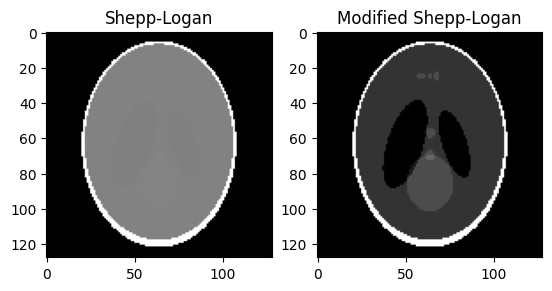

In [2]:
# The original Shepp-Logan
ph = shepp_logan(128, modified=False)
plt.subplot(1, 2, 1)
plt.title('Shepp-Logan')
plt.imshow(ph, cmap='gray')

# Modified Shepp-Logan for better contrast
ph = shepp_logan(128, modified=True)
plt.subplot(1, 2, 2)
plt.title('Modified Shepp-Logan')
plt.imshow(ph, cmap='gray')
plt.show()

## Non-Square Phantom

Generate a phantom with different width and height dimensions:

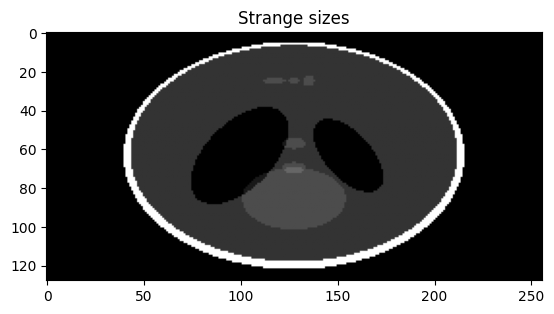

In [3]:
# Generate phantoms with different sizes
ph = shepp_logan((128, 256))
plt.title('Strange sizes')
plt.imshow(ph, cmap='gray')
plt.show()

## 3D Phantom

Create a 3D phantom and display all slices:

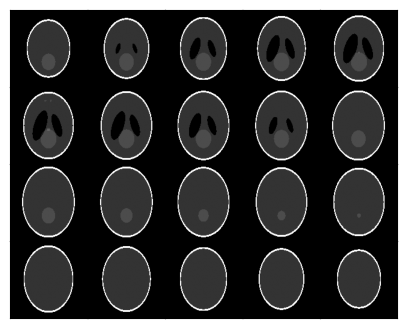

In [4]:
# Get a 3D phantom
ph = shepp_logan((128, 128, 20), zlims=(-.5, .5))

# Fancy dancing to nicely show all slices on same plot
nx = int(np.ceil(np.sqrt(ph.shape[-1])))
fig = plt.figure(figsize=(nx, nx))
for ii in range(ph.shape[-1]):
    ax = fig.add_subplot(nx, nx, ii+1)
    plt.imshow(ph[..., ii], cmap='gray')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_aspect('equal')
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

## Generate Dataset

Generate multiple Shepp-Logan phantom samples and save them as PNG files:

In [5]:
import os
import json
import re
import numpy as np
import matplotlib.pyplot as plt
from phantominator import shepp_logan

# Configuration
phantom_type = 'modified'  # 'original' or 'modified'
nsamples = 1000  # Number of samples to generate
image_size = 128  # Size of the phantom

# LoRA dataset output (images + metadata.jsonl)
output_folder = 'generated_data'
images_dir = output_folder  
metadata_jsonl_path = os.path.join(output_folder, 'metadata.jsonl')

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Base seed
seed = 42

# Get base ellipse parameters to understand structure
# We need the base E matrix to modify specific features
modified = (phantom_type == 'modified')
base_phantom = shepp_logan(image_size, modified=modified, ret_E=True)
_, E_base = base_phantom

# Feature definitions helpers
# 0: Outer Skull (Bone)
# 1: Inner Skull (Brain boundary)
# 2,3: Ventricles (Left/Right) - "Larger black things"
# 4: Central Structure (CSF?) - "Big thing in the middle"
# 5,6: Additional central small structures
# 7,8,9: Base lesions (bottom)

def _get_existing_indices(folder):
    indices = set()
    if os.path.isdir(folder):
        for name in os.listdir(folder):
            if name.endswith('.png'):
                try:
                    indices.add(int(name.split('.')[0]))
                except ValueError: pass
    return indices

existing_indices = _get_existing_indices(images_dir)
start_index = 1
while start_index in existing_indices:
    start_index += 1

pad_width = 5
mode = 'a' if os.path.exists(metadata_jsonl_path) else 'w'

print(f"Generating {nsamples} controlled samples in '{output_folder}'...")

created = 0

with open(metadata_jsonl_path, mode) as jsonl_file:
    for j in range(nsamples):
        file_index = start_index + j
        file_name = f"{file_index:0{pad_width}d}.png"
        output_path = os.path.join(images_dir, file_name)
        
        # Skip if exists
        if os.path.exists(output_path):
            continue

        # Per-sample RNG
        rng = np.random.default_rng(seed + file_index)
        
        # --- 1. Control Parameters (Sampled from distributions) ---
        
        # Feature 1: Ventricles Size (Ellipses 2, 3)
        ventricle_scale = rng.uniform(0.6, 1.8)
        
        # Feature 2: Bone Thickness (Outer layer E0 vs E1)
        # Base thickness is roughly 0.027. We scale this gap.
        bone_thickness_scale = rng.uniform(0.5, 3.0)
        
        # Feature 3: White+Gray Matter Size (Brain Size - E1 container)
        brain_size_scale = rng.uniform(0.85, 1.15)
        
        # Feature 4: Number of Lesions
        num_lesions = rng.integers(0, 6) # 0 to 5 lesions
        
        # Feature 5: Size of Lesions
        lesion_size_scale = rng.uniform(0.5, 2.5)
        
        # Feature 6: CSV Size (Big thing in middle - E4)
        csf_size_scale = rng.uniform(0.6, 1.8)
        
        # --- 2. Construct Modified E Matrix ---
        E = E_base.copy()
        
        # Apply Brain Scale (Feature 3)
        # Scale E1 (Inner Skull / Brain container)
        E[1, 1] *= brain_size_scale # Major
        E[1, 2] *= brain_size_scale # Minor
        
        # Apply Bone Thickness (Feature 2)
        # We adjust E0 (Outer Skull) to be E1 + (BaseGap * scale)
        base_gap_major = E_base[0, 1] - E_base[1, 1]
        base_gap_minor = E_base[0, 2] - E_base[1, 2]
        
        E[0, 1] = E[1, 1] + (base_gap_major * bone_thickness_scale)
        E[0, 2] = E[1, 2] + (base_gap_minor * bone_thickness_scale)
        
        # Apply Ventricle Scale (Feature 1) -> Ellipses 2 and 3
        # These are inside the brain, so valid scale is relative to brain_size_scale * intrinsic
        for idx in [2, 3]:
            # Scale dimensions
            E[idx, 1] = E_base[idx, 1] * brain_size_scale * ventricle_scale
            E[idx, 2] = E_base[idx, 2] * brain_size_scale * ventricle_scale
            # Scale position (move with brain expansion)
            E[idx, 3] = E_base[idx, 3] * brain_size_scale
            E[idx, 4] = E_base[idx, 4] * brain_size_scale
            
        # Apply CSF Scale (Feature 6) -> Ellipse 4
        for idx in [4]:
            E[idx, 1] = E_base[idx, 1] * brain_size_scale * csf_size_scale
            E[idx, 2] = E_base[idx, 2] * brain_size_scale * csf_size_scale
            E[idx, 3] *= brain_size_scale
            E[idx, 4] *= brain_size_scale

        # Feature 4 & 5: Lesions
        # We rebuild the E list. Keep E0-E6 (Structures).
        # We replace E7,8,9 (Base Lesions) with `num_lesions` new/modified lesions.
        
        # Start with structural parts
        E_list = [row for row in E[0:7]]
        
        # Base lesion dimensions (from E7 in base)
        base_lesion_dims = (0.046, 0.046) # approx
        
        # Generate new lesions
        for l_idx in range(num_lesions):
            # Scale size
            l_a = base_lesion_dims[0] * brain_size_scale * lesion_size_scale
            l_b = base_lesion_dims[1] * brain_size_scale * lesion_size_scale
            
            # Random position inside brain (E1)
            # Simple rejection sampling
            found = False
            for attempt in range(50):
                # Random x, y roughly in [-0.6, 0.6] scaled
                lx = rng.uniform(-0.5, 0.5) * brain_size_scale
                ly = rng.uniform(-0.7, 0.6) * brain_size_scale # avoiding bottom extreme
                
                # Check if inside ellipsoid E1 (roughly)
                # ((x-0)/E1_a)^2 + ((y-0)/E1_b)^2 < 0.8 (stay away from skull)
                term = (lx / E[1, 1])**2 + (ly / E[1, 2])**2
                
                if term < 0.8:
                    found = True
                    break
            
            if not found:
                lx, ly = 0, -0.6 * brain_size_scale # Fallback position
            
            # Create lesion row: [Gray, a, b, x, y, theta]
            # Gray = 0.1 (Bright spot)
            E_list.append([0.1, l_a, l_b, lx, ly, 0.0])
            
        E_final = np.array(E_list)
        
        # --- 3. Random Affine Transformations (Global & Local) ---
        # Add slight randomness to differentiate dataset as requested, 
        # independent of the controlled features.
        
        # A. Global Head Movement (Patient positioning)
        # Rotation (-10 to 10 degrees)
        rot_angle_global = np.deg2rad(rng.uniform(-10, 10))
        # Translation (shift in FOV)
        shift_x_global = rng.uniform(-0.05, 0.05)
        shift_y_global = rng.uniform(-0.05, 0.05)
        
        # Apply Global Rotation to all centers
        c, s = np.cos(rot_angle_global), np.sin(rot_angle_global)
        x_orig = E_final[:, 3].copy()
        y_orig = E_final[:, 4].copy()
        
        E_final[:, 3] = x_orig * c - y_orig * s + shift_x_global
        E_final[:, 4] = x_orig * s + y_orig * c + shift_y_global
        
        # Apply Global Rotation start angle
        E_final[:, 5] += rot_angle_global

        # B. Local Element Jitter (Organic asymmetry)
        # Slight indepedent movement of internal structures (indices 1+)
        # We treat the E0 (skull) as the anchor (already globally moved).
        n_elems = len(E_final)
        if n_elems > 1:
            # Random small shifts
            E_final[1:, 3] += rng.normal(0, 0.008, n_elems-1)
            E_final[1:, 4] += rng.normal(0, 0.008, n_elems-1)
            # Random small rotations
            E_final[1:, 5] += rng.normal(0, np.deg2rad(2.0), n_elems-1)

        # Generate Image
        ph = shepp_logan(image_size, modified=modified, E=E_final)
        ph = np.clip(ph, 0, 1)
        
        # --- 4. Generate Caption ---
        features = []
        
        # Ventricles
        if ventricle_scale < 0.85: features.append("small ventricles")
        elif ventricle_scale > 1.3: features.append("large ventricles")
        else: features.append("normal ventricles")
        
        # Bone
        if bone_thickness_scale < 0.8: features.append("thin skull bone")
        elif bone_thickness_scale > 1.5: features.append("thick skull bone")
        else: features.append("normal skull bone")
        
        # Brain Size
        if brain_size_scale < 0.95: features.append("small brain area")
        elif brain_size_scale > 1.05: features.append("large brain area")
        else: features.append("normal brain area")
        
        # Lesions
        if num_lesions == 0: features.append("no lesions")
        elif num_lesions == 1: features.append("1 lesion")
        else: features.append(f"{num_lesions} lesions")
        
        if num_lesions > 0:
            if lesion_size_scale < 0.8: features.append("small lesions")
            elif lesion_size_scale > 1.5: features.append("large lesions")
            else: features.append("normal sized lesions")
            
        # CSF
        if csf_size_scale < 0.8: features.append("small CSF")
        elif csf_size_scale > 1.3: features.append("large CSF")
        else: features.append("normal CSF")
        
        caption = "Synthetic Shepp-Logan phantom with " + ", ".join(features)
        
        # Save Image
        plt.figure(figsize=(6, 6))
        plt.imshow(ph, cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(output_path, bbox_inches='tight', dpi=150)
        plt.close()
        
        # Save Metadata
        jsonl_file.write(json.dumps({'file_name': file_name, 'text': caption}) + "\n")
        
        created += 1
        if created % 100 == 0:
            print(f"Created {created}/{nsamples} images")

print(f"Finished. Created {created} images in {output_folder}")


Generating 1000 controlled samples in 'generated_data'...
Created 100/1000 images
Created 200/1000 images
Created 300/1000 images
Created 400/1000 images
Created 500/1000 images
Created 600/1000 images
Created 700/1000 images
Created 800/1000 images
Created 900/1000 images
Created 1000/1000 images
Finished. Created 1000 images in generated_data


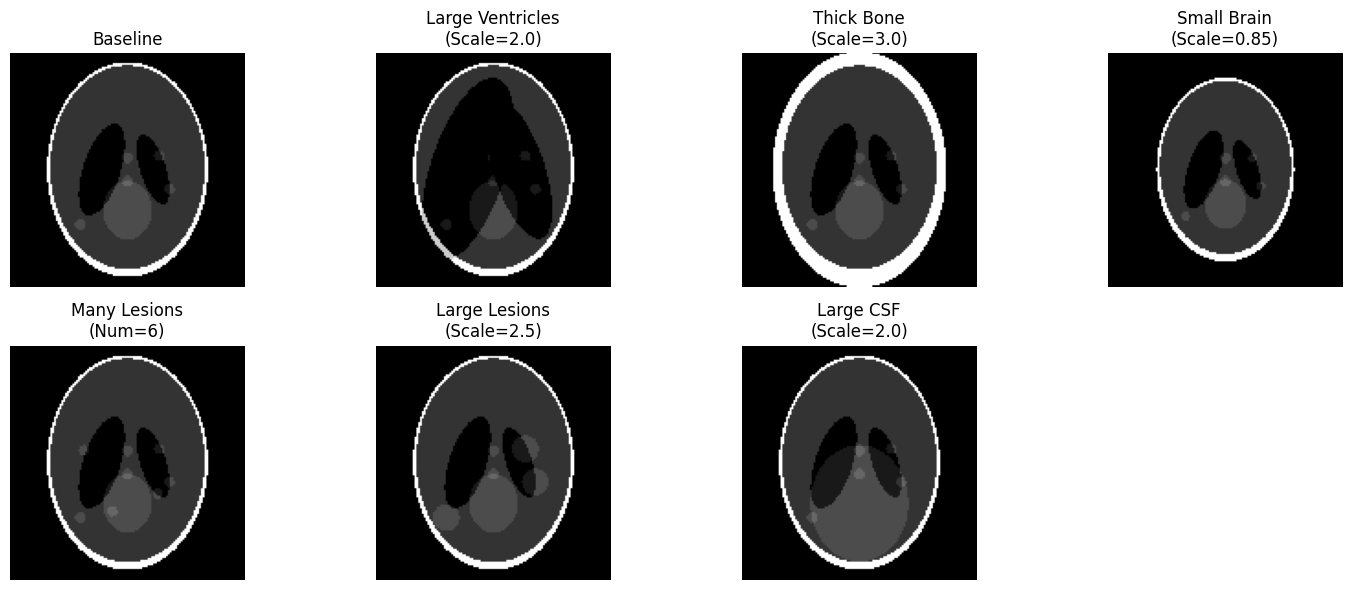

In [6]:
# --- Visualization of Controlled Parameters ---

def generate_custom_phantom(
    ventricle_scale=1.0, 
    bone_thickness_scale=1.0, 
    brain_size_scale=1.0, 
    num_lesions=3, 
    lesion_size_scale=1.0, 
    csf_size_scale=1.0
):
    # Base
    modified = True
    base_phantom = shepp_logan(128, modified=modified, ret_E=True)
    _, E_base = base_phantom
    E = E_base.copy()
    
    # 1. Brain Scale (E1)
    E[1, 1] *= brain_size_scale
    E[1, 2] *= brain_size_scale
    
    # 2. Bone Thickness (E0)
    base_gap_major = E_base[0, 1] - E_base[1, 1]
    base_gap_minor = E_base[0, 2] - E_base[1, 2]
    E[0, 1] = E[1, 1] + (base_gap_major * bone_thickness_scale)
    E[0, 2] = E[1, 2] + (base_gap_minor * bone_thickness_scale)
    
    # 3. Ventricles (E2, E3)
    for idx in [2, 3]:
        E[idx, 1] = E_base[idx, 1] * brain_size_scale * ventricle_scale
        E[idx, 2] = E_base[idx, 2] * brain_size_scale * ventricle_scale
        E[idx, 3] = E_base[idx, 3] * brain_size_scale
        E[idx, 4] = E_base[idx, 4] * brain_size_scale

    # 4. CSF (E4)
    for idx in [4]:
        E[idx, 1] = E_base[idx, 1] * brain_size_scale * csf_size_scale
        E[idx, 2] = E_base[idx, 2] * brain_size_scale * csf_size_scale
        E[idx, 3] *= brain_size_scale
        E[idx, 4] *= brain_size_scale
        
    # 5. Lesions
    # Keep E0-E6
    E_list = [row for row in E[0:7]]
    
    # Add `num_lesions`
    rng = np.random.default_rng(42) # fixed seed for vis
    base_lesion_dims = (0.046, 0.046)
    
    for i in range(num_lesions):
        l_a = base_lesion_dims[0] * brain_size_scale * lesion_size_scale
        l_b = base_lesion_dims[1] * brain_size_scale * lesion_size_scale
        
        # Random positions (deterministic via fixed seed)
        lx = rng.uniform(-0.5, 0.5) * brain_size_scale
        ly = rng.uniform(-0.6, 0.5) * brain_size_scale
        
        E_list.append([0.1, l_a, l_b, lx, ly, 0])
        
    E_final = np.array(E_list)
    return shepp_logan(128, modified=modified, E=E_final)

# Plotting
titles = [
    "Baseline",
    "Large Ventricles\n(Scale=2.0)",
    "Thick Bone\n(Scale=3.0)",
    "Small Brain\n(Scale=0.85)",
    "Many Lesions\n(Num=6)",
    "Large Lesions\n(Scale=2.5)",
    "Large CSF\n(Scale=2.0)"
]

params = [
    {}, # Baseline
    {'ventricle_scale': 2.0},
    {'bone_thickness_scale': 3.0},
    {'brain_size_scale': 0.85},
    {'num_lesions': 6},
    {'lesion_size_scale': 2.5},
    {'csf_size_scale': 2.0}
]

plt.figure(figsize=(15, 6))
for i, (title, p) in enumerate(zip(titles, params)):
    ph = generate_custom_phantom(**p)
    plt.subplot(2, 4, i+1)
    plt.imshow(ph, cmap='gray', vmin=0, vmax=1)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()